In [1]:
from pathlib import Path
from IPython.display import Image as IPImage
from PIL import Image
from matplotlib import pylab as plt
from matplotlib import gridspec
import matplotlib.cm as cm

import seaborn as sns
sns.set(font_scale=1.2)

from nmtpytorch.translator import Translator
from nmtpytorch.utils.data import to_var
from nmtpytorch.utils.data import make_dataloader

import numpy as np
import torch

import tqdm

from skimage import transform

In [2]:
def standardize(x, mode=None):
    return (x - x.min()) / (x.max() - x.min())

def torch2ndarray(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = np.transpose(x.cpu().numpy(), (1, 2, 0))
    return np.clip(img * std[None, None] + mean[None, None], a_min=0, a_max=1)

def get_sentences():
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/tok/test_2017_flickr.lc.norm.tok.en") as f:
        english_sentences = f.read().split("\n")[:-1]
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/tok/test_2017_flickr.lc.norm.tok.fr") as f:
        french_sentences = f.read().split("\n")[:-1]
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/image_splits/test_2017_flickr.txt") as f:
        image_indices = f.read().split("\n")[:-1]
    indices = {}
    for index, english_sentence in enumerate(english_sentences):
        indices[english_sentence] = (french_sentences[index], image_indices[index])
    return indices

In [3]:
def plot(model, data, idx, model_name=None, english2goldstandard=None, smooth=True, transpose=False, sigma=20, maxnorm=True, only_mean_std=False, image=None):#sample, image, smooth=True):
    # Unpack
    src, hyp, img, ta, ia = data[idx]
    
    if isinstance(english2goldstandard, dict):
        try:
            fr, imagename = english2goldstandard[model.src_vocab.idxs_to_sent(src, debug=True).replace(" <eos>", "")]
            src_sentence = model.src_vocab.idxs_to_sent(src, debug=True)
            print(f"{src_sentence}\n{fr}")
            image = Image.open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/image_splits/mmt_images/task1/" + imagename)
            mplot = plt.imshow(np.asarray(image))
            image.save(f"sentence_pngs/{src_sentence}.png")
            return "/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/image_splits/mmt_images/task1/" + imagename
        except KeyError:
            print("unk makes finding image impossible")
            return None
    if image:
        old_img = Image.open(image)
        img = Image.open(image)
        quad = np.asarray(old_img)[:]
        quad = quad.shape[0]
        img = img.resize((quad, quad))
        img = np.asarray(img)
    # Textual attention as matrix
    tas = np.stack(ta).T
    src = model.src_vocab.idxs_to_sent(src, debug=True).split(' ')
    hyp = model.trg_vocab.idxs_to_sent(hyp, debug=True).split(' ')
    # 6 for 6x6 or 14 for 14x14, etc.
    img_att_dim = int(np.sqrt(ia[0].shape[0]))
    spat_dim = (img_att_dim, img_att_dim)
    ias = np.stack(ia).reshape((-1, img_att_dim, img_att_dim))
    if only_mean_std:

        return tas, ias
    if transpose:
        ias = np.transpose(ias, (0, 2, 1))
    if smooth:
        upscale = img.shape[0]/img_att_dim
        if upscale <= 1:
            upscale = 1.000000001
        alpha = [transform.pyramid_expand(
            ias[ii], upscale=upscale, sigma=sigma) for ii in range(ias.shape[0])]
    else:
        alpha = [transform.resize(
            ias[ii], [img.shape[0], img.shape[1]], mode='reflect') for ii in range(ias.shape[0])]
        
    kwargs = {}
    if maxnorm:
        kwargs['vmax'] = max([a.max() for a in alpha])

    # Compute wxh for placing image attention
    n_words = len(hyp) + 1
    w = int(np.round(np.sqrt(n_words)))
    h = 5
    w = n_words // h + int(n_words % h > 0)
      
    # Create a grid
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    # Get subplot
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(grid[0])
    
    # Plot text attention
    sns.heatmap(tas, xticklabels=hyp, yticklabels=src, cmap='Greys',
                square=True, linewidths=0, cbar=False, ax=ax1)
    plt.yticks(rotation=0)

    inner_grid = gridspec.GridSpecFromSubplotSpec(w, h, grid[1], wspace=0.05, hspace=0.1)
    ax = plt.subplot(inner_grid[0])
    print(" ".join(src[:-1]), " ".join(hyp[:-1]))
    # Show image
    ax.imshow(img)
    ax.set_axis_off()
    # 1->black, 0->white
    plt.set_cmap(cm.jet)
    for ii in range(ias.shape[0]):
        ax = plt.subplot(inner_grid[ii + 1])
        ax.text(0, -10, hyp[ii], color='black', backgroundcolor='#ffffff', fontsize=12)
        # Show image
        ax.imshow(img)
        ax.imshow(alpha[ii], alpha=0.6, **kwargs)
        ax.set_axis_off()
    if isinstance(model_name, str):
        if len("_".join(src)) > 200:
            src = "{}_unk".format(len(src))
        filename = "_".join(src)
        plt.tight_layout()
        plt.savefig(f"{model_name}/{idx}_{filename}.png")
    plt.figure()
    plt.imshow(ias.mean(0))
    plt.axis('off')
    plt.colorbar()
    if isinstance(model_name, str):
        plt.close("all")
    return tas, ias

In [4]:
def process(modeltype, split='test_2017_flickr'):
    root = Path('/home/rebekka/t2b/Projekte/vision/mmt_experiments') / modeltype
    model_file = sorted(list(root.glob('*.best.meteor_*ckpt')),
        key=lambda x: float(x.name.split('best.meteor_')[-1].replace('.ckpt', '')))[-1]
    parameter_dict = {"disable_filters": False,
                     "splits": split,
                     "batch_size": 64,
                     "beam_size": 12,
                     "max_len" : 200,
                     "lp_alpha": 0,
                     "device_id": "gpu",
                     "models": [model_file],
                     "override": [],
                     "stochastic": False,
                     "beam_func": "beam_search",
                     "splits": split,
                     "source": None,
                     "task_id": None}
    translator = Translator(**parameter_dict)
    model = translator.instances[0]
    model = model.cuda()
    dataset = model.load_data(translator.splits[0], parameter_dict["batch_size"], mode="test")
    # Load and decode
    loader = make_dataloader(dataset)
    data = []
    for batch in tqdm.tqdm(loader, unit='batch'):
        #batch = to_var(batch_)
        batch.device("cuda")
        img_att = [[] for i in range(batch.size)]
        txt_att = [[] for i in range(batch.size)]
        hyps = [[] for i in range(batch.size)]
        srcs = batch[model.sl].data.cpu().t().tolist()
        imgs = batch['image'].data.cpu()
        fini = torch.zeros(batch.size).long().cuda()
        ctx_dict = model.encode(batch)
        # Get initial hidden state
        h_t = model.dec.f_init(ctx_dict)
        tile = range(batch.size)
        y_t = model.get_bos(batch.size).cuda()
        # Iterate for 100 timesteps
        for t in range(100):
            logp, h_t = model.dec.f_next(ctx_dict, model.dec.emb(y_t), h_t)
            tatt = model.dec.txt_alpha_t.cpu().data.clone().numpy()
            iatt = model.dec.img_alpha_t.cpu().data.clone().numpy()
            top_scores, y_t = logp.data.topk(1, largest=True)
            hyp = y_t.cpu().numpy().tolist()
            y_t = y_t.squeeze(1)
            for idx, w in enumerate(hyp):
                if 2 not in hyps[idx]:
                    hyps[idx].append(w[0])
                    txt_att[idx].append(tatt[:, idx])
                    img_att[idx].append(iatt[:, idx])

            fini = fini | y_t.eq(2).squeeze().long()
            if fini.sum() == batch.size:
                break

        for s, h, ta, ia, img in zip(srcs, hyps, txt_att, img_att, imgs):
            data.append((s, h, torch2ndarray(img.unsqueeze(0)), ta, ia))

    # Put into correct order
    data = [data[i] for i, j in sorted(
        enumerate(loader.batch_sampler.orig_idxs), key=lambda k: k[1])]
    # Sort by increasing length
    data = sorted(data, key=lambda x: len(x[0]))
    return data, model

In [5]:

res4f, m1 = process('mmt_complete_dataset_paper/mmt-task-en-fr-multimodalatt/best/')
res4f_random, m2 = process('mmt_random_replacement/mmt-task-en-fr-multimodalatt_random_replacement/best/')
res4f_0_remaining, m3 = process('mmt_0_remaining/mmt-task-en-fr-multimodalatt_0_remaining/best/')
res4f_1_remaining, m4 = process('mmt_1_remaining/mmt-task-en-fr-multimodalatt_1_remaining/best/')
res4f_2_remaining, m5 = process('mmt_2_remaining/mmt-task-en-fr-multimodalatt_2_remaining/best/')
res4f_3_remaining, m6 = process('mmt_3_remaining/mmt-task-en-fr-multimodalatt_3_remaining/best/')
res4f_4_remaining, m7 = process('mmt_4_remaining/mmt-task-en-fr-multimodalatt_4_remaining/best/')
res4f_6_remaining, m8 = process('mmt_6_remaining/mmt-task-en-fr-multimodalatt_6_remaining/best/')
res4f_12_remaining, m9 = process('mmt_12_remaining/mmt-task-en-fr-multimodalatt_12_remaining/best/')
res4f_20_remaining, m10 = process('mmt_20_remaining/mmt-task-en-fr-multimodalatt_20_remaining/best/')
#res4f_random_pos, m11 = process('mmt_random_pos_replacement/mmt-task-en-fr-multimodalatt_random_pos_replacement/best/')
#res4f_random_pos_dt, m12 = process('mmt_random_pos_replacement_of_dt/mmt-task-en-fr-multimodalatt_random_pos_replacement_dt/best/')
res4f_random_pos_nn, m13 = process('mmt_random_pos_replacement_of_nn/best/')
res4f_random_pos_vb, m14 = process('mmt_random_pos_replacement_of_vb/best/')
res4f_random_pos_jj, m15 = process('mmt_random_pos_replacement_of_jj/best/')
#res4f_random_pos_prp, m16 = process('mmt_random_pos_replacement_of_prp/mmt-task-en-fr-multimodalatt_random_pos_replacement_prp/best/')
#res4f_random_pos_in, m17 = process('mmt_random_pos_replacement_of_in/mmt-task-en-fr-multimodalatt_random_pos_replacement_in/best/')
resf_random_pos_nn4, m18 = process('mmt_random_pos_replacement_of_nn4/mmt-task-en-fr-multimodalatt_random_pos_replacement_nn_only4/best/')
#resf_random_pos_nn3, m19 = process('mmt_random_pos_replacement_of_nn3/mmt-task-en-fr-multimodalatt_random_pos_replacement_nn_only3/best/')
res4f_random_4, m20 = process('mmt_random_replacement4/')

<class 'list'>
set()


1000sents [00:00, 73154.34sents/s]
1000sents [00:00, 145995.47sents/s]
100%|██████████| 35/35 [00:05<00:00,  6.01batch/s]
1000sents [00:00, 57636.23sents/s]
1000sents [00:00, 205552.76sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.40batch/s]
1000sents [00:00, 58705.93sents/s]
1000sents [00:00, 197379.01sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.07batch/s]
1000sents [00:00, 246216.85sents/s]
1000sents [00:00, 199320.63sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.22batch/s]
1000sents [00:00, 244722.80sents/s]
1000sents [00:00, 178861.58sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.11batch/s]
1000sents [00:00, 237839.75sents/s]
1000sents [00:00, 207248.94sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.28batch/s]
1000sents [00:00, 40207.68sents/s]
1000sents [00:00, 202096.17sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  5.94batch/s]
1000sents [00:00, 225585.11sents/s]
1000sents [00:00, 200310.62sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.37batch/s]
1000sents [00:00, 209046.25sents/s]
1000sents [00:00, 196989.67sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.16batch/s]
1000sents [00:00, 54492.00sents/s]
1000sents [00:00, 192948.02sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.32batch/s]
1000sents [00:00, 50499.10sents/s]
1000sents [00:00, 51748.95sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.31batch/s]
791sents [00:00, 206504.07sents/s]

<class 'list'>
set()



791sents [00:00, 139704.16sents/s]
100%|██████████| 31/31 [00:04<00:00,  6.41batch/s]
624sents [00:00, 199744.00sents/s]

<class 'list'>
set()



624sents [00:00, 110357.80sents/s]
100%|██████████| 30/30 [00:03<00:00,  8.06batch/s]
518sents [00:00, 27970.31sents/s]

<class 'list'>
set()



518sents [00:00, 97986.27sents/s]
100%|██████████| 27/27 [00:03<00:00,  8.43batch/s]
1000sents [00:00, 61823.68sents/s]
1000sents [00:00, 190157.50sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.19batch/s]


1000


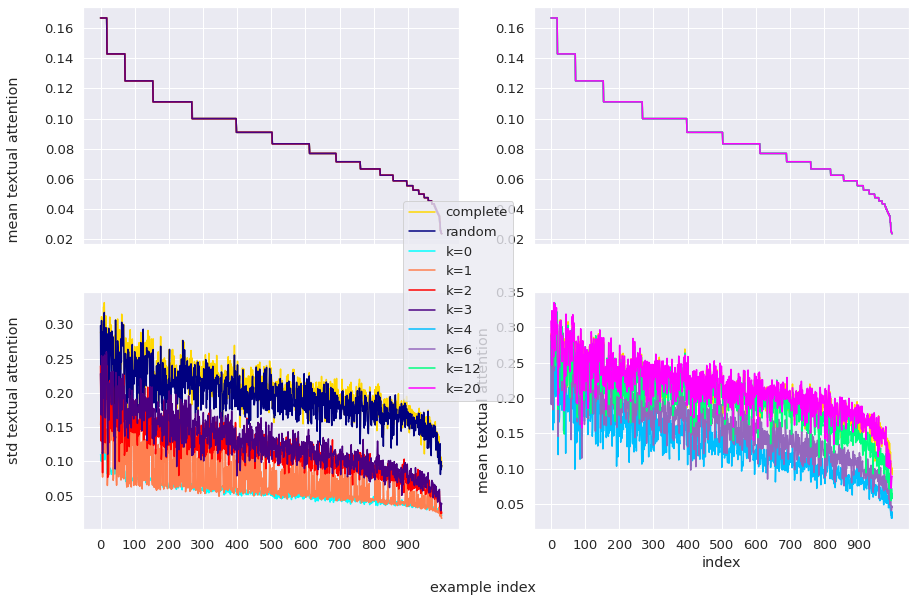

7
0 [(560, 0.8377701), (146, 0.80664545), (343, 0.7620685), (613, 0.7566298), (229, 0.7219364), (972, 0.71652263), (218, 0.7005852), (788, 0.67899936), (908, 0.67330784), (239, 0.65997434), (655, 0.659075), (995, 0.6531309), (449, 0.640765), (726, 0.6306027), (366, 0.61930496)]
1 [(9, 0.89200467), (709, 0.8601473), (851, 0.8545688), (624, 0.8301323), (910, 0.8178871), (329, 0.7827092), (781, 0.77726746), (288, 0.75996757), (602, 0.7493203), (401, 0.7462561), (246, 0.7454076), (512, 0.74461955), (879, 0.7422981), (789, 0.71791625), (56, 0.70505714)]
2 [(183, 0.85634416), (642, 0.76927423), (137, 0.7655828), (757, 0.7511576), (927, 0.729131), (978, 0.72563934), (910, 0.7219286), (734, 0.71571416), (760, 0.7004675), (624, 0.6996077), (391, 0.6981377), (906, 0.6932198), (709, 0.6871578), (655, 0.6854817), (985, 0.6780533)]
3 [(602, 0.9334556), (31, 0.897194), (480, 0.8887241), (924, 0.87670374), (113, 0.85312045), (381, 0.84440994), (203, 0.8335679), (47, 0.8256709), (81, 0.80455816), (442

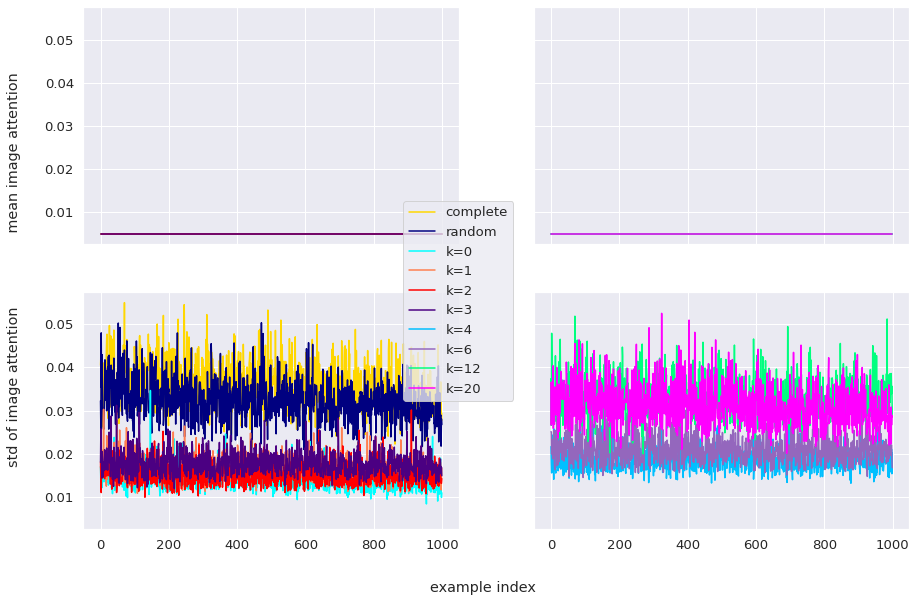

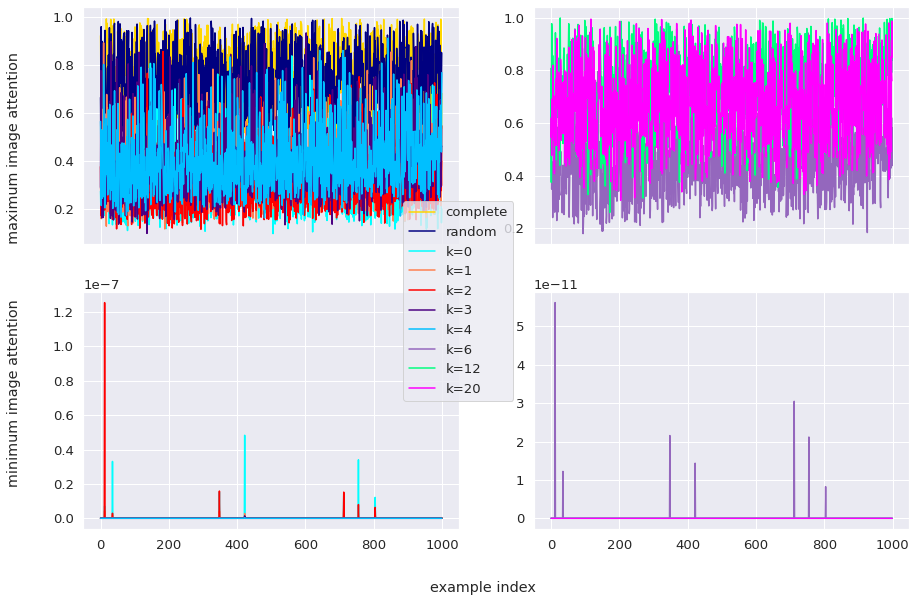

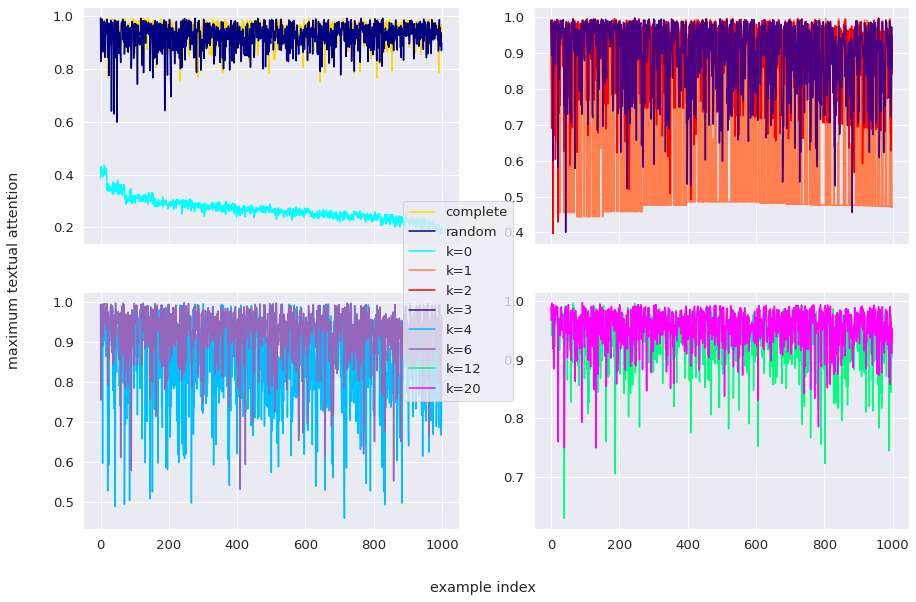

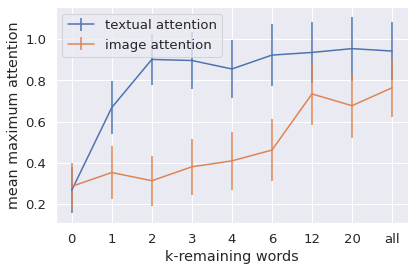

In [6]:
english2gold = get_sentences()
print(len(res4f))
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
ax.set_xticks([i for i in range(0, len(res4f), 100)])
ax2.set_xticks([i for i in range(0, len(res4f), 100)])
ax3.set_xticks([i for i in range(0, len(res4f), 100)])
ax4.set_xticks([i for i in range(0, len(res4f), 100)])
labels = []
arrays_t = []
arrays_ts = []
ta_means, ta_stds, ia_means_c, ia_stds_c, ia_maxs_c, ia_mins_c, ta_maxs_c = [], [], [], [], [], [], []
for idx in range(len(res4f)):
    #imagename = plot(m1, res4f, idx, "complete", english2gold, smooth=True, maxnorm=True, only_mean_std=True)
    ta, ia = plot(m1, res4f, idx, "complete", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ta_maxs_c.append(ta.max())
    ia_maxs_c.append(ia.max())
    ia_mins_c.append(ia.min())
    ta_means.append(ta_mean)
    ta_stds.append(ta_std)
    ia_means_c.append(ia_mean)
    ia_stds_c.append(ia_std)
    #plt.close("all")
l1, = ax.plot(ta_means, color="gold")
ax3.plot(ta_means, color="gold")
ax2.plot(ta_stds, color="gold")
ax4.plot(ta_stds, color="gold")
labels.append("complete")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds = [], []
ta_means, ta_stds, ia_means_r, ia_stds_r, ia_maxs_r, ia_mins_r, ta_maxs_r = [], [], [], [], [], [], []
for idx in range(len(res4f_random)):
    ta, ia = plot(m2, res4f_random, idx, "random", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ta_maxs_r.append(ta.max())
    ia_maxs_r.append(ia.max())
    ia_mins_r.append(ia.min())
    ta_means.append(ta_mean)
    ta_stds.append(ta_std)
    ia_means_r.append(ia_mean)
    ia_stds_r.append(ia_std)
    ##plt.close("all")
    #print(idx)
l2, = ax.plot(ta_means, color="navy")
ax2.plot(ta_stds, color="navy")
labels.append("random")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_0, ia_stds_0, ia_maxs_0, ia_mins_0, ta_maxs_0 = [], [], [], [], [], [], []
for idx in range(len(res4f_0_remaining)):
    ta, ia = plot(m3, res4f_0_remaining, idx, "0_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ia_maxs_0.append(ia.max())
    ia_mins_0.append(ia.min())
    ta_means.append(ta_mean)
    ta_maxs_0.append(ta.max())
    ia_means_0.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_0.append(ia_std)
    #plt.close("all")
    #print(idx)
l3, = ax.plot(ta_means, color="aqua")
ax2.plot(ta_stds, color="aqua")
labels.append("k=0")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_1, ia_stds_1, ia_maxs_1, ia_mins_1, ta_maxs_1 = [], [], [], [], [], [], []
for idx in range(len(res4f_1_remaining)):
    ta, ia  = plot(m4, res4f_1_remaining, idx, "1_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ia_std = ia.std()
    ta_std = ta.std()
    ia_maxs_1.append(ia.max())
    ia_mins_1.append(ia.min())
    ta_means.append(ta_mean)
    ta_maxs_1.append(ta.max())
    ia_means_1.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_1.append(ia_std)
    #plt.close("all")
    #print(idx)
l4, = ax.plot(ta_means, color="coral")
ax2.plot(ta_stds, color="coral")
labels.append("k=1")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_2, ia_stds_2, ia_maxs_2, ia_mins_2, ta_maxs_2 = [], [], [], [], [], [], []
for idx in range(len(res4f_2_remaining)):
    ta, ia = plot(m5, res4f_2_remaining, idx, "2_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_maxs_2.append(ta.max())
    ia_std = ia.std()
    ta_std = ta.std()
    ia_maxs_2.append(ia.max())
    ia_mins_2.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_2.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_2.append(ia_std)
    #plt.close("all")
    #print(idx)
l5, = ax.plot(ta_means, color="red")
ax2.plot(ta_stds, color="red")
labels.append("k=2")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_3, ia_stds_3, ia_maxs_3, ia_mins_3, ta_maxs_3 = [], [], [], [], [], [], []
for idx in range(len(res4f_3_remaining)):
    ta, ia = plot(m6, res4f_3_remaining, idx, "3_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_3.append(ia.max())
    ia_mins_3.append(ia.min())
    ta_maxs_3.append(ta.max())
    ta_means.append(ta_mean)
    ia_means_3.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_3.append(ia.std())
    #plt.close("all")
    #print(idx)
l6, = ax.plot(ta_means, color="indigo")
ax2.plot(ta_stds, color="indigo")
labels.append("k=3")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_4, ia_stds_4, ia_maxs_4, ia_mins_4, ta_maxs_4 = [], [], [], [], [], [], []
for idx in range(len(res4f_4_remaining)):
    ta, ia =plot(m7, res4f_4_remaining, idx, "4_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ta_maxs_4.append(ta.max())
    ia_maxs_4.append(ia.max())
    ia_mins_4.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_4.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_4.append(ia.std())
    #plt.close("all")
    #print(idx)
l7, = ax3.plot(ta_means, color="deepskyblue")
ax4.plot(ta_stds, color="deepskyblue")
labels.append("k=4")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_6, ia_stds_6, ia_maxs_6, ia_mins_6, ta_maxs_6 = [], [], [], [], [], [], []
for idx in range(len(res4f_6_remaining)):
    ta, ia = plot(m8, res4f_6_remaining, idx, "6_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_6.append(ia.max())
    ta_maxs_6.append(ta.max())
    ia_mins_6.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_6.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_6.append(ia.std())
    #plt.close("all")
    #print(idx)
l8, = ax3.plot(ta_means, color="tab:purple")
ax4.plot(ta_stds, color="tab:purple")
labels.append("k=6")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_12, ia_stds_12, ia_maxs_12, ia_mins_12, ta_maxs_12 = [], [], [], [], [], [], []
for idx in range(len(res4f_12_remaining)):
    ta, ia = plot(m9, res4f_12_remaining, idx, "12_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_12.append(ia.max())
    ta_maxs_12.append(ta.max())
    ia_mins_12.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_12.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_12.append(ia.std())
    #plt.close("all")
    #print(idx)
l9, = ax3.plot(ta_means, color="springgreen")
ax4.plot(ta_stds, color="springgreen")
labels.append("k=12")
arrays_t.append(np.array(ta_means).mean())
arrays_ts.append(np.array(ta_means).std())
ta_means, ta_stds, ia_means_20, ia_stds_20, ia_maxs_20, ia_mins_20, ta_maxs_20 = [], [], [], [], [], [], []
for idx in range(len(res4f_20_remaining)):
    ta, ia = plot(m10, res4f_20_remaining, idx, "20_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ta_maxs_20.append(ta.max())
    ia_maxs_20.append(ia.max())
    ia_mins_20.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_20.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_20.append(ia.std())
    #plt.close("all")
    #print(idx)
l10, = ax3.plot(ta_means, color="fuchsia")
ax4.plot(ta_stds, color="fuchsia")
labels.append("k=20")
plt.xlabel("index")
plt.ylabel("mean textual attention")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc='center')
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'std textual attention                mean textual attention', ha='center', va='center', rotation='vertical')
plt.show()
# Good samples: 464, 615, 7, 103
idx = np.random.choice(len(res4f), size=1)[0]
idx = 7
english2gold = get_sentences()
print(idx)
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True, sharey=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ia_means_c, color="gold")
ax2.plot(ia_stds_c, color="gold")
l2, = ax.plot(ia_means_r, color="navy")
ax2.plot(ia_stds_r, color="navy")
l3, = ax.plot(ia_means_0, color="aqua")
ax2.plot(ia_stds_0, color="aqua")
l4, = ax.plot(ia_means_1, color="coral")
ax2.plot(ia_stds_1, color="coral")
l5, = ax.plot(ia_means_2, color="red")
ax2.plot(ia_stds_2, color="red")
l6, = ax.plot(ia_means_3, color="indigo")
ax2.plot(ia_stds_3, color="indigo")
l7, = ax3.plot(ia_means_4, color="deepskyblue")
ax4.plot(ia_stds_4, color="deepskyblue")
l8, = ax3.plot(ia_means_6, color="tab:purple")
ax4.plot(ia_stds_6, color="tab:purple")
l9, = ax3.plot(ia_means_12, color="springgreen")
ax4.plot(ia_stds_12, color="springgreen")
l10, = ax3.plot(ia_means_20, color="fuchsia")
ax4.plot(ia_stds_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'std of image attention                mean image attention', ha='center', va='center', rotation='vertical')
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ia_maxs_c, color="gold")
ax2.plot(ia_mins_c, color="gold")
l2, = ax.plot(ia_maxs_r, color="navy")
ax2.plot(ia_mins_r, color="navy")
l3, = ax.plot(ia_maxs_0, color="aqua")
ax2.plot(ia_mins_0, color="aqua")
l4, = ax.plot(ia_maxs_1, color="coral")
ax2.plot(ia_mins_1, color="coral")
l5, = ax.plot(ia_maxs_2, color="red")
ax2.plot(ia_mins_2, color="red")
l6, = ax.plot(ia_maxs_3, color="indigo")
ax2.plot(ia_mins_3, color="indigo")
l7, = ax.plot(ia_maxs_4, color="deepskyblue")
ax2.plot(ia_mins_4, color="deepskyblue")
l8, = ax3.plot(ia_maxs_6, color="tab:purple")
ax4.plot(ia_mins_6, color="tab:purple")
l9, = ax3.plot(ia_maxs_12, color="springgreen")
ax4.plot(ia_mins_12, color="springgreen")
l10, = ax3.plot(ia_maxs_20, color="fuchsia")
ax4.plot(ia_mins_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'minimum image attention            maximum image attention', ha='center', va='center', rotation='vertical')
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ta_maxs_c, color="gold")
l2, = ax.plot(ta_maxs_r, color="navy")
l3, = ax.plot(ta_maxs_0, color="aqua")
l4, = ax3.plot(ta_maxs_1, color="coral")
l5, = ax3.plot(ta_maxs_2, color="red")
l6, = ax3.plot(ta_maxs_3, color="indigo")
l7, = ax2.plot(ta_maxs_4, color="deepskyblue")
l8, = ax2.plot(ta_maxs_6, color="tab:purple")
l9, = ax4.plot(ta_maxs_12, color="springgreen")
l10, = ax4.plot(ta_maxs_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'maximum textual attention', ha='center', va='center', rotation='vertical')

arrays = []
arrays_i = []
arrays_s = []
arrays_si = []
for array in [ta_maxs_0, ta_maxs_1, ta_maxs_2, ta_maxs_3, ta_maxs_4, ta_maxs_6, ta_maxs_12, ta_maxs_20, ta_maxs_c]:
    arrays.append(np.asarray(array).mean())
    arrays_s.append(np.asarray(array).std())
highest_image_attention_indices = {}
k2abl = {1:1, 2:2, 3:3, 4:4, 0:0, 5:6, 6:12, 7:20, 8:"complete", "random":"random"}
for k, array in enumerate([ia_maxs_0, ia_maxs_1, ia_maxs_2, ia_maxs_3, ia_maxs_4, ia_maxs_6, ia_maxs_12, ia_maxs_20, ia_maxs_c]):
    arrays_i.append(np.asarray(array).mean())
    arrays_si.append(np.asarray(array).std())
    a = [(index, array[index]) for index in range(len(array))]
    
    highest_image_attention_indices[k] = sorted(a, reverse=True, key=lambda x: x[1])[0:15]
for key, top in highest_image_attention_indices.items():
    print(key, top)
fig, ax = plt.subplots()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels([0, 1, 2, 3, 4, 6, 12, 20, "all"])
plt.xlabel("k-remaining words")
plt.ylabel("mean maximum attention")
ax.errorbar([i for i in range(9)], arrays, arrays_si, label="textual attention")
ax.errorbar([i for i in range(9)], arrays_i, arrays_si, label="image attention")
plt.legend()
array = [(index,  ia_maxs_r[index]) for index in range(len(ia_maxs_r))]
highest_image_attention_indices["random"] = sorted(a, reverse=True, key=lambda x: x[1])[0:15]
plt.tight_layout()
plt.savefig("tex_im_att.png")

In [7]:
"""
for k, top_a in highest_image_attention_indices.items():
    print(k)
    
    if isinstance(k, int):
        if k < 8:
            continue
    
    k = k2abl[k]
    for sample in top_a:
        imagename = plot(m1, res4f, sample[0], f"complete_model_{k}", english2gold, smooth=True, maxnorm=True)
        tas, ias = plot(m1, res4f, sample[0], f"complete_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m2, res4f_random, sample[0], f"random_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m3, res4f_0_remaining, sample[0], f"0_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m4, res4f_1_remaining, sample[0], f"1_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m5, res4f_2_remaining, sample[0], f"2_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m6, res4f_3_remaining, sample[0], f"3_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m7, res4f_4_remaining, sample[0], f"4_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m8, res4f_6_remaining, sample[0], f"6_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m9, res4f_12_remaining, sample[0], f"12_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m10, res4f_20_remaining, sample[0], f"20_rem_model_{k}", image=imagename, smooth=True, maxnorm=True)
        tas, ias = plot(m20, res4f_random_4, sample[0], f"random4_model_{k}", image=imagename, smooth=True, maxnorm=True)

for sample in highest_image_attention_indices["random"]:
    imagename = plot(m1, res4f, sample[0], f"complete_model_complete", english2gold, smooth=True, maxnorm=True)
    #tas, ias = plot(m11, res4f_random_pos, sample[0], f"random_pos_model", image=imagename, smooth=True, maxnorm=True)
    #tas, ias = plot(m12, res4f_random_pos_dt, sample[0], f"random_pos_model_dt", image=imagename, smooth=True, maxnorm=True)
    #tas, ias = plot(m14, res4f_random_pos_vb, sample[0], f"random_pos_model_vb", image=imagename, smooth=True, maxnorm=True)
    tas, ias = plot(m13, res4f_random_pos_nn, sample[0], f"random_pos_model_nn", image=imagename, smooth=True, maxnorm=True)
    #tas, ias = plot(m15, res4f_random_pos_jj, sample[0], f"random_pos_model_jj", image=imagename, smooth=True, maxnorm=True)
    #tas, ias = plot(m16, res4f_random_pos_prp, sample[0], f"random_pos_model_prp", image=imagename, smooth=True, maxnorm=True)
    #tas, ias = plot(m17, res4f_random_pos_in, sample[0], f"random_pos_model_in", image=imagename, smooth=True, maxnorm=True)

for index in range(len(res4f_random_pos_vb)):
    print(index)
    plot(m14, res4f_random_pos_vb, index)
    plt.close("all")
"""
vb_corresponding_indices = [527, 93, 508, False, 166, 10, 24, False, 171, 489, False, 395, 19, 633, 668]

for index, sample in enumerate(highest_image_attention_indices["random"]):
    if vb_corresponding_indices[index]:
        print(sample)
        imagename = plot(m1, res4f, sample[0], f"complete_model_complete", english2gold, smooth=True, maxnorm=True)
        tas, ias = plot(m14, res4f_random_pos_vb, vb_corresponding_indices[index], f"random_pos_model_vb", image=imagename, smooth=True, maxnorm=True)
"""
for index in range(len(res4f_random_pos_jj)):
    print(index)
    plot(m15, res4f_random_pos_jj, index)
    plt.close("all")
"""
jj_corresponding_indices = [False, False, False, False, False, 107, False, False, 111, 356, False, 283, False, False, 511]
for index, sample in enumerate(highest_image_attention_indices["random"]):
    if jj_corresponding_indices[index]:
        print(sample)
        imagename = plot(m1, res4f, sample[0], f"complete_model_complete", english2gold, smooth=True, maxnorm=True)
        tas, ias = plot(m15, res4f_random_pos_jj, jj_corresponding_indices[index], f"random_pos_model_jj", image=imagename, smooth=True, maxnorm=True)

for sample in range(len(resf_random_pos_nn4)):
    plot(m18, resf_random_pos_nn4, sample, smooth=True, maxnorm=True)
    plt.close("all")

nn_corresponding_indices = [248, False, 225, False, False, False, False, False, False, 210, False, False, False, 348, 387]
for index, sample in enumerate(highest_image_attention_indices["random"]):
    if nn_corresponding_indices[index]:
        print(sample)
        imagename = plot(m1, res4f, sample[0], f"complete_model_random", english2gold, smooth=True, maxnorm=True)
        tas, ias = plot(m18, resf_random_pos_nn4, nn_corresponding_indices[index], f"random_pos_model_nn4", image=imagename, smooth=True, maxnorm=True)


(706, 0.9937505)
a woman walking down a street lined with cars in the dark . <eos>
une femme marchant dans une rue bordée de voitures dans l&apos; obscurité .
a woman jamming down a street lined with cars in the dark . une femme marchant dans une rue bordée de voitures dans la rue sombre .
(138, 0.9933303)
two baseball players talking on the field <eos>
deux joueurs de baseball discutent sur le terrain
two baseball players surfing on the field deux joueurs de baseball surfant sur le terrain
(678, 0.9932499)
a monster truck flies upside down over a mound of dirt . <eos>
un &quot; monster truck &quot; vole la tête en bas au dessus d&apos; un monticule de terre .
a monster truck catches upside down over a mound of dirt . un monster truck &quot; est la tête en bas par-dessus un monticule de terre .
(245, 0.99217826)
several children playing on a court with balls <eos>
plusieurs enfants jouant sur un terrain avec des ballons
several children giggling on a court with balls plusieurs enfants 

hummingbird in a art arrest on the tiles . un homme se trouve dans un équipement de sécurité sur la rampe .
three haircuts with hiking cacti engage in label . trois hommes avec des pancartes de musique se battent en tenue .
a wrestilng of surfs and adolescents , red jack un groupe de personnes et d&apos; un arbre , en train de manger , rouge
dealer jumping on the slideshow racket with purple weight un homme sautant sur la scène de jeu avec des micros violets
conductor and fedex in the handlebar of the pestle des gens et une femme au milieu de la route
a madison spike surrounding a farmhouse covered wiring . une voie ferrée entourant une route recouverte de graffitis .
justice of parasailer with rocky minny and fingers . une photo de gens avec des montagnes rocheuses et des montagnes .
a mailman beak training a black antique end . un homme jouant vers un jouet noir en laisse .
a teacher observers intricate bananas on large figures . un vendeur de légumes alimentaires à la caisse sur de 

three breaks sit at an outdoor cookie pidgin testing . trois femmes sont assises à une table de restaurant en plein air .
a movement of brown mops lining a takeout madison way un groupe de personnes marron traversent une rue en ville
white slopes and pine circles with scrubs to the geishas des hommes blancs et des pins avec des cierges magiques sur le rivage
a man on a i-pad resting with a victory inflatable un homme sur un bateau se reposant avec un appareil photo
a harley of sashes sit under a tehelka brush . un groupe de personnes sont assises sous un panneau de signalisation .
a geisha of diapers riding in a plant quilt . un groupe de personnes circulant dans une salle de classe .
a attraction of u.s. flow presses fly in six-pack . un groupe de skieurs de l&apos; avion s&apos; amuse en pleine ascension .
a thing taking jumpsuits in an <unk> fondue skirt . un homme qui prend des photos dans un bâtiment de secours <unk> .
two elderly inwards sitting in lavender of a cheer megaphone d

a small unison outside with creation wrists blowing around her art . une petite fille en train de manger avec des fleurs colorés autour de son bras .
a man and two runners playing on the affair of the architecture un homme et deux filles jouant sur le bord de la plage
two male paintbrush elements from opposing corners competing for a chelsea . deux garçons sont tous des femmes aux cheveux noirs se battent pour une photo .
a pastry riding a barbecuing on the glow wearing a mouse . un homme faisant du vélo sur la piste portant un casque .
a snowdrift marlboro in a very narrow sleigh takes a slingshot . un homme debout dans une zone très étroite prend une photo .
right of a answer on calm spray under a golden basket . l&apos; eau d&apos; un homme sur un bateau au bord d&apos; une rivière .
a cage eats from a pabst using his raids and stacks . un homme mange un morceau à un homme utilisant son ordinateur et des boissons .
a field sliding a blue curry jackhammer outside on their trampoline 

a bicycler and her amount under a award of a giant magnifying artwork un enfant et son enfant sous une statue d&apos; une clôture géante
a cry trikes on a plastic weight while lying on the transport . un chien fait un coup de cheval sur un terrain en plastique tandis qu&apos; il est allongé par terre .
cooks are dressed up in fasteners and fundraiser morse at a festival . des gens sont habillés en costumes et jouent de la guitare lors d&apos; un festival .
a lone woman standing on the fly-fishing d of a tigger foliage . une femme solitaire debout sur la route en face d&apos; un camion de pompiers .
a <unk> , his sledgehammer and his best complexion , his county . un homme , sa tête et son chien en laisse , son chien .
the transit delight dives the keep the bieber from the other rescue . le coureur de football plonge sur le point de l&apos; équipe de l&apos; autre équipe .
soloists are rafting down a fast bushel in a blue sticker roadway . des gens font du rafting sur une colline très v

a clipboard of blue and green neon with small clogs <unk> the trampoline . une étendue d&apos; eau bleue et verte avec de petits enfants en arrière-plan .
snowsuits tutu , shoreline , and match , on a paved pedestrian street . des hommes avec des parapluies , un appareil photo , et un match , sur une rue pavée pavée .
a building schipper brick <unk> with a tree covered ugg in the lobby . un bâtiment de briques dribble avec un arbre recouvert de graffitis en arrière-plan .
a couple with a baby woodworking towards a large costco in the shrine . un couple avec un bébé debout vers un gros bloc dans la neige .
a stomach waling of the expertise from behind a <unk> that reads boston . un homme saute du sol derrière un mur qui lit la nuit .
a cavern is wearing a furry purple passer with two ally hoops attached . un homme porte un bonnet violet et un chapeau de cow-boy attaché avec deux paniers de fleurs .
the boy smiles for a bout worker with black plays on the <unk> . le garçon sourit pour un

a light brown male hipsters with antlers and a eik of hippie and fairgrounds . un chien brun clair avec des lunettes de soleil et un groupe de filles et des épées .
a young girl wearing a green monster with a bmx entrance-way on the text . une jeune fille portant un t-shirt vert avec un sac à dos dans l&apos; eau .
a drive of positions in a yellow sticking <unk> the <unk> of a river . un groupe de personnes dans un bateau jaune au bord d&apos; une rivière .
a peek-a-boo is eating at a florist on the other contact of a germany . un homme mange une discussion sur l&apos; autre côté d&apos; une foule .
a wife in a white and black snacks wheel crouches to catch a customer . une femme en robe à carreaux blanche et noire s&apos; accroupit pour attraper un ballon .
a white and tan farmhand is barking behind a alcohol at a canister hand . un chien blanc et brun aboyant derrière une clôture dans un champ de noël .
a stomach is setting her morning down on a individual while holding her cigar . u

a europe with an orange taupe is jumping over a speck laying on the ft . un homme avec un t-shirt orange saute par-dessus un tronc allongé sur le sol .
a scenic lease of a sand-dune covered in balloon pulls on a partly cloudy day . une vue depuis une colline recouverte de montagnes se trouve sur une journée nuageuse .
a semi with his downsteps crossed wears square messi standing in chevrolet of a fireplace . un homme avec les bras croisés porte des vêtements à motifs , debout devant un bureau .
a i-pod is taking a hunting of a large arch with his plume in it . un homme prend une photo d&apos; un grand bâtiment avec sa tête dessus .
a knee works on a cgt bystander , with his saw drying all around him . un homme travaille sur un tas de bois , avec sa main est tout en avec son bras autour de lui .
a blue district on the road in the bloom of a place with loggers of tire un camion bleu sur la route au milieu d&apos; un lac avec des montagnes en arrière-plan
a cycle with angles with a vote b

this is a scene of a stand-up of water with ribs in the polaris surrounded by rings . c&apos; est une photo d&apos; une foule de personnes avec des gens en arrière-plan entouré par des arbres .
a young scooper , wearing a demo and <unk> , is holding the miniature of an adult . une jeune femme , vêtue d&apos; un t-shirt et d&apos; un chapeau , tient le visage d&apos; un adulte .
a slim asian coupe in a long white turtle and blue hat stringing gift in a silverware kitchen . un homme asiatique asiatique avec une longue chemise blanche et un chapeau bleu fait du thé dans une cuisine .
a chung with a metropolis flying above a beach with motorbikes on the forestry and in the water . un bateau avec un bâton au-dessus d&apos; une plage avec des montagnes sur le rivage et dans l&apos; eau .
a brown labor running through the curb with a red and gray partially deflated grace in his typewriter . un chien brun courant dans le sable avec un ballon rouge et gris jouant dans sa gueule .
a <unk> with w

a fixture in a red top is walking down the middle of the button-up as coeds approach in the halter . une personne en haut rouge marche au milieu de la rue tandis que des spectateurs font du roller en ville .
two people walking on a cobbled path surrounded by shrubbery with a swap of mule and propeller range in the hip . deux personnes marchant sur un chemin pavé , entouré d&apos; arbres avec une sorte de montagne et des montagnes russes au premier plan .
jeeps wearing red and white clothing on a mom silhouette , , some lying down , other crouching with arcs watching . des hommes vêtus de tenues rouges et blancs sur un chemin de terre , certains sont allongés , , certains assis avec des spectateurs regardant .
a large rocky and grassy <unk> is near a burka where a pen in a blue closeby and dark numerals stands . une grande falaise rocheuse et verdoyante est près d&apos; une fontaine où une femme en t-shirt bleu et pantalon foncé est debout .
a young switch wearing a red and gold basebal

a young puff with dark hair pulled back at her neck and a dark shirt holding a white piece of paper with a black wedding <unk> drawn on it with an older woman holding jugglers in the forefront out of dash une jeune femme aux cheveux foncés est allongée à dos sur son téléphone portable et un homme sombre tenant un morceau de papier blanc avec une femme âgée tenant des lunettes de soleil en arrière-plan
(706, 0.9937505)
a woman walking down a street lined with cars in the dark . <eos>
une femme marchant dans une rue bordée de voitures dans l&apos; obscurité .
a lady walking down a army lined with tools in the cluster . une femme marchant dans une rue bordée de gens en arrière-plan .
(678, 0.9932499)
a monster truck flies upside down over a mound of dirt . <eos>
un &quot; monster truck &quot; vole la tête en bas au dessus d&apos; un monticule de terre .
a bowtie mine flies upside down over a midair of relaxing . un ouvrier de rue se met du bas sur une rampe de béton .
(655, 0.9905138)
pin

performance3 stuck in hay playing un chien plonge en courant


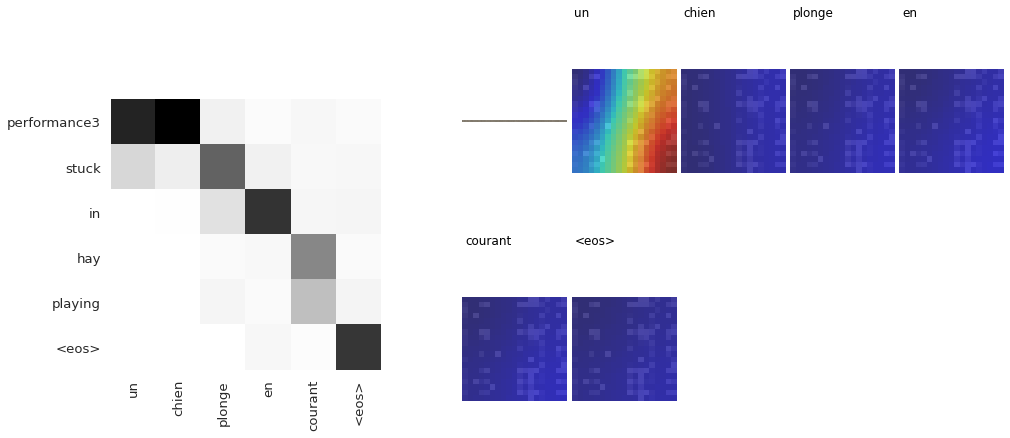

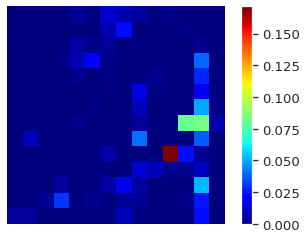

In [8]:
idx = 7
tas, ias = plot(m2, res4f_random, idx, smooth=True, maxnorm=True)

<unk> <unk> <unk> <unk> <unk> un chien brun jouant de la randonnée .


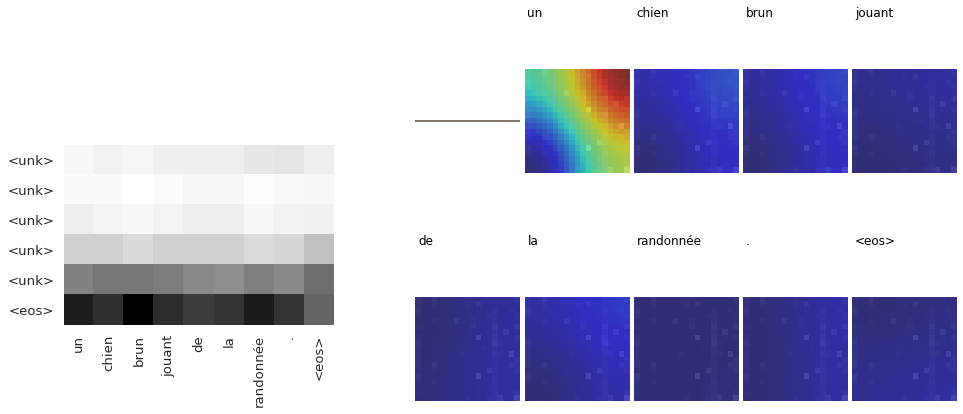

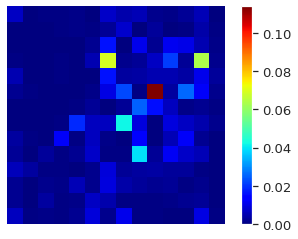

In [9]:
tas, ias = plot(m3, res4f_0_remaining, idx, smooth=True, maxnorm=True)

puppy <unk> <unk> <unk> <unk> un chien brun nageant dans l&apos; herbe


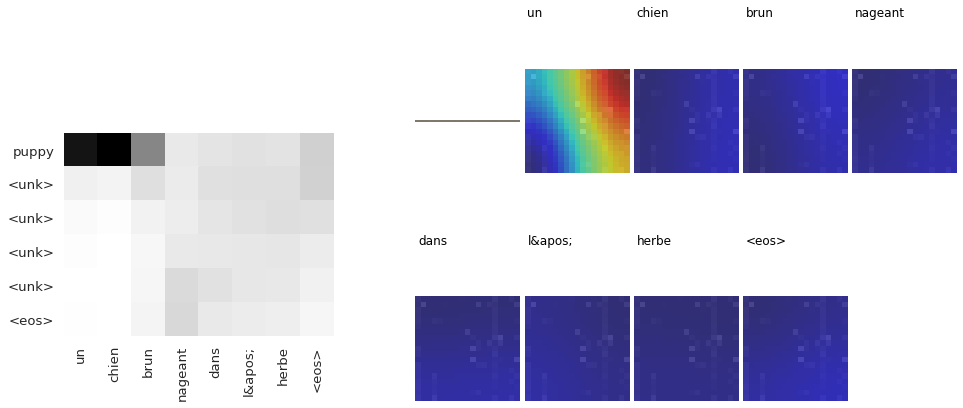

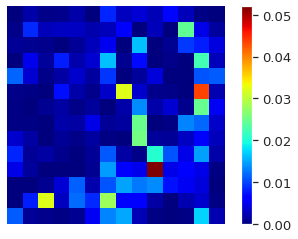

In [10]:
tas, ias = plot(m4, res4f_1_remaining, idx, smooth=True, maxnorm=True)

puppy stuck <unk> <unk> <unk> un chien brun se repose dans l&apos; herbe .


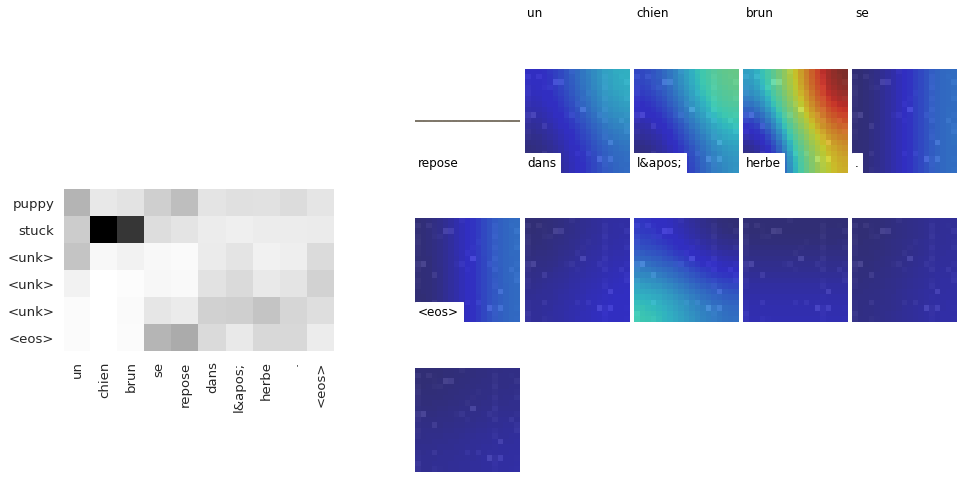

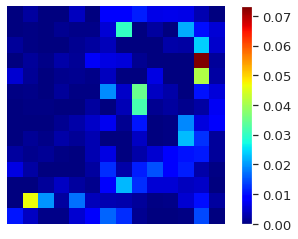

In [11]:
tas, ias = plot(m5, res4f_2_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in <unk> <unk> un chiot dans l&apos; eau .


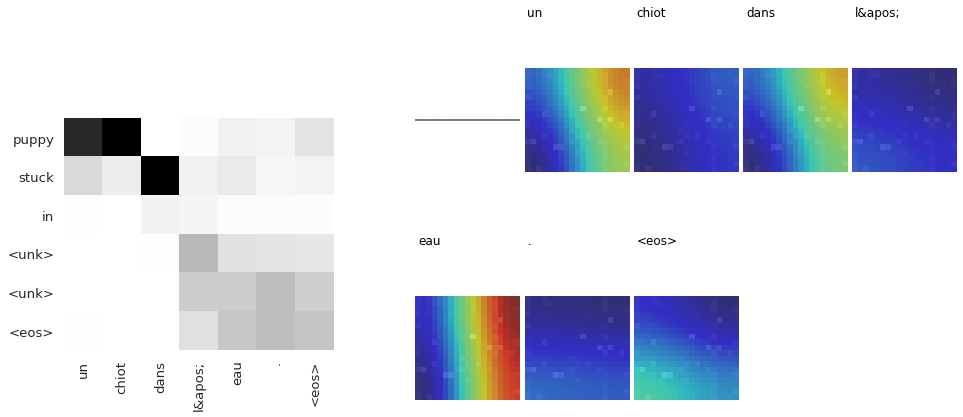

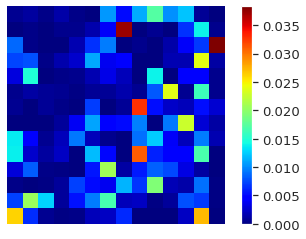

In [12]:
tas, ias = plot(m6, res4f_3_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in hay <unk> un chiot couché dans l&apos; herbe .


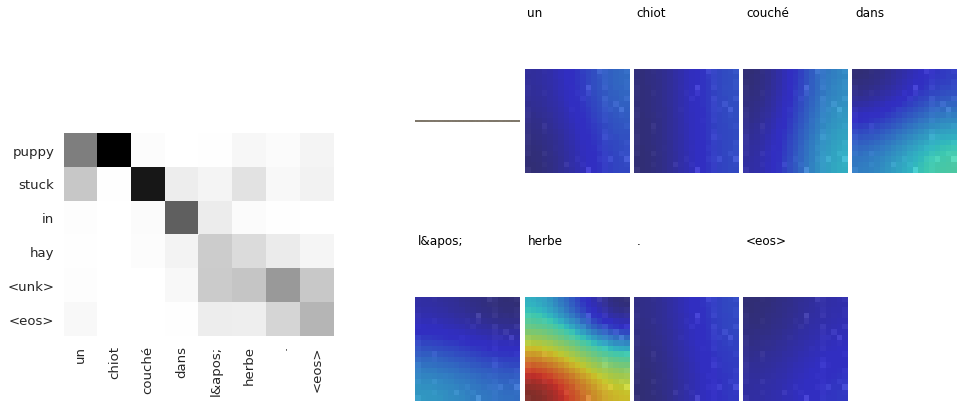

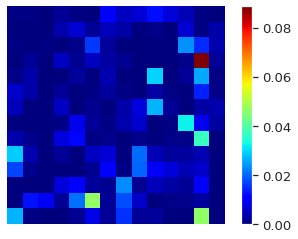

In [13]:
tas, ias = plot(m7, res4f_4_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in hay playing un chiot allongé dans les bois .


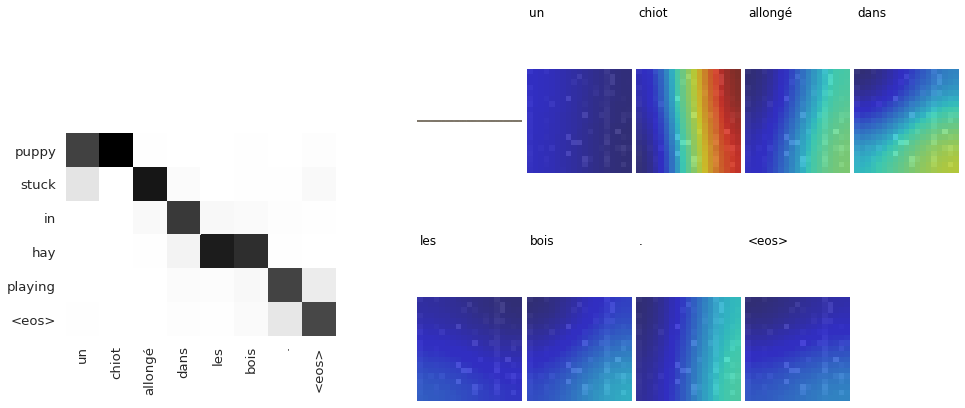

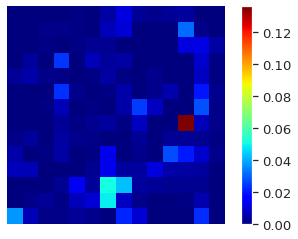

In [14]:
tas, ias = plot(m8, res4f_6_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in hay playing un chiot est allongé dans le foin .


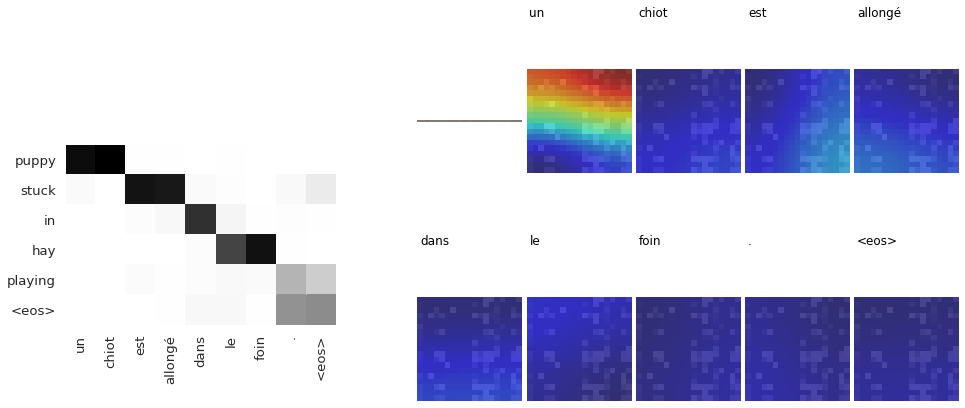

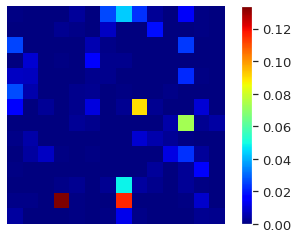

In [15]:
tas, ias = plot(m9, res4f_12_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in hay playing un chiot tire dans le foin en train de jouer


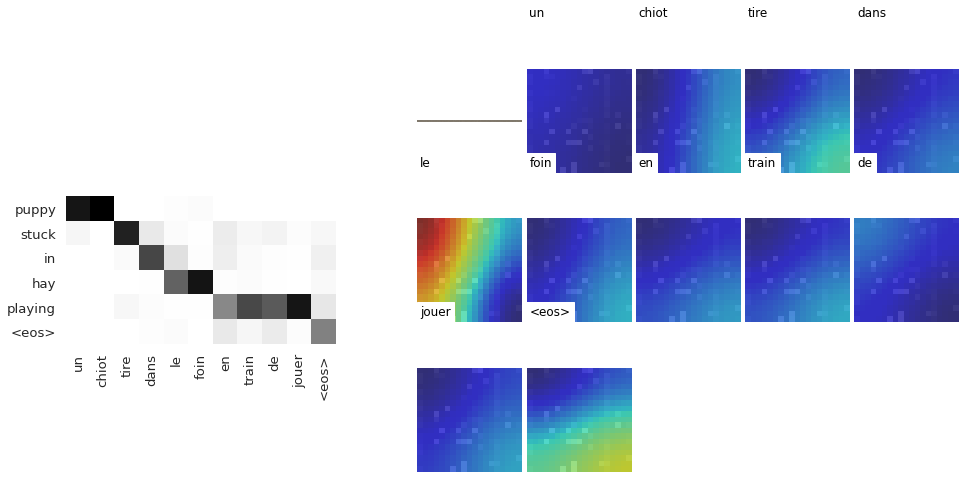

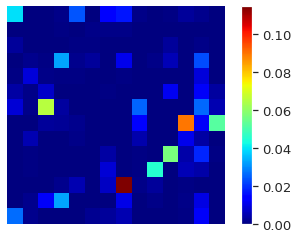

In [16]:
tas, ias = plot(m10, res4f_20_remaining, idx, smooth=True, maxnorm=True)

puppy stuck in hay playing <eos>
un chiot au milieu du foin en train de jouer
puppy stuck in hay playing un chiot navigue dans du foin en train de jouer
puppy stuck in hay playing un chiot est allongé dans le foin .
<unk> <unk> <unk> <unk> <unk> un chien brun jouant de la randonnée .


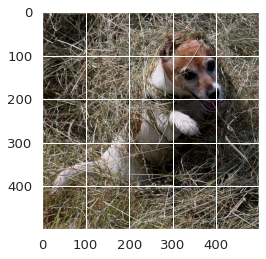

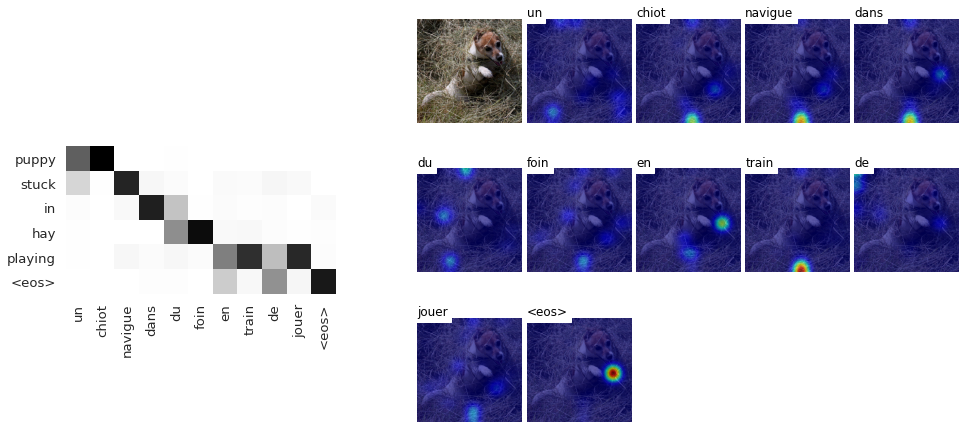

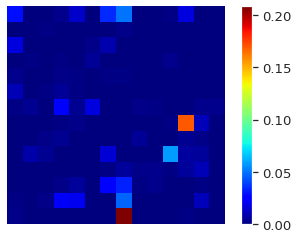

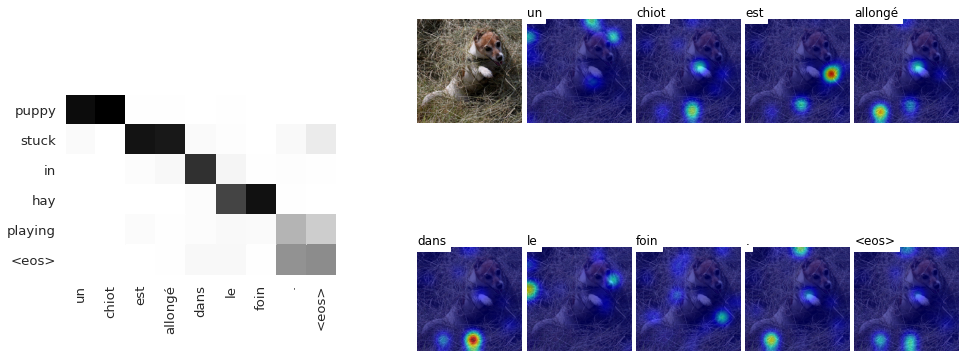

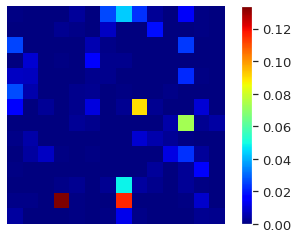

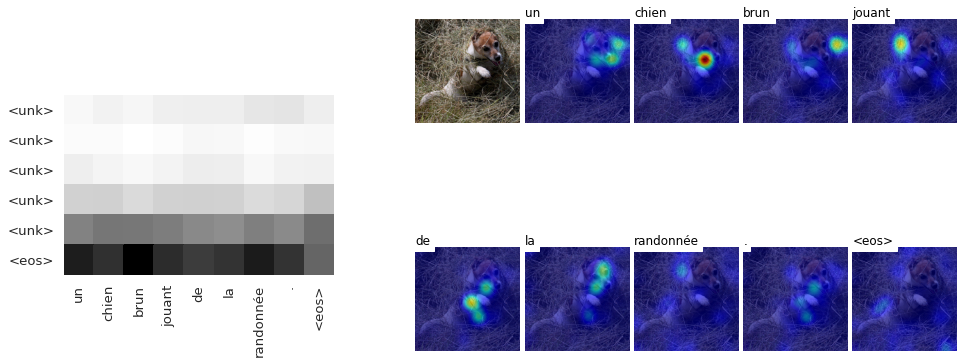

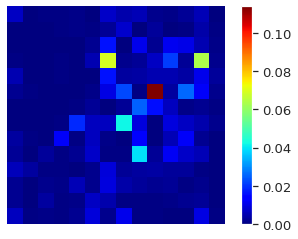

In [17]:
imagename = plot(m1, res4f, idx, english2goldstandard=english2gold, smooth=True, maxnorm=True)
tas, ias = plot(m1, res4f, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m9, res4f_12_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m3, res4f_0_remaining, idx, image=imagename, smooth=True, maxnorm=True)

a monster truck flies upside down over a mound of dirt . <eos>
un &quot; monster truck &quot; vole la tête en bas au dessus d&apos; un monticule de terre .
a monster truck flies upside down over a light-colored of dirt . un monster truck vole la tête en bas sur un bloc de terre .


NameError: name 'm11' is not defined

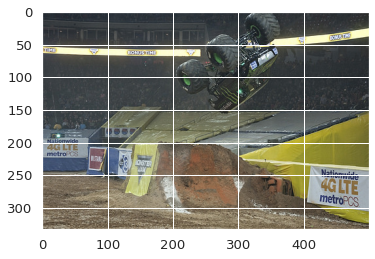

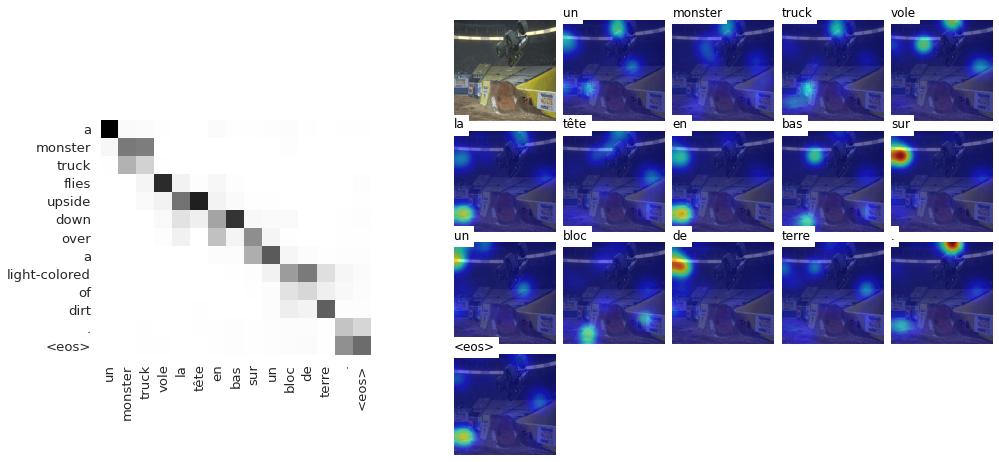

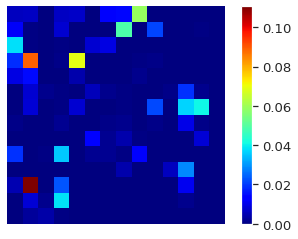

In [18]:
idx = 678
nn_idx = 225
imagename = plot(m1, res4f, idx, english2goldstandard=english2gold, smooth=True, maxnorm=True)
tas, ias = plot(m2, res4f_random, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m11, res4f_random_pos, idx, image=imagename, smooth=True, maxnorm=True)
#tas, ias = plot(m13, res4f_random_pos_nn, idx, image=imagename, smooth=True, maxnorm=True)
#tas, ias = plot(m14, res4f_random_pos_vb, idx, image=imagename, smooth=True, maxnorm=True)
#tas, ias = plot(m15, res4f_random_pos_jj, idx, image=imagename, smooth=True, maxnorm=True)
#tas, ias = plot(m16, res4f_random_pos_prp, idx, image=imagename, smooth=True, maxnorm=True)
#tas, ias = plot(m17, res4f_random_pos_in, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m18, resf_random_pos_nn4, nn_idx, image=imagename, smooth=True, maxnorm=True)

plot(m1, res4f, idx, smooth=True, maxnorm=True)

In [ ]:
idx = 138
imagename = plot(m1, res4f, idx, english2goldstandard=english2gold, smooth=True, maxnorm=True)
tas, ias = plot(m3, res4f_0_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m4, res4f_1_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m5, res4f_2_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m6, res4f_3_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m7, res4f_4_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m8, res4f_6_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m9, res4f_12_remaining, idx, image=imagename, smooth=True, maxnorm=True)
tas, ias = plot(m10, res4f_20_remaining, idx, image=imagename, smooth=True, maxnorm=True)
plot(m1, res4f, idx, smooth=True, maxnorm=True)